In [31]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data import Subset
import random
import math
import timm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import wandb


In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

In [132]:
class ResizeAndPad:
    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, img):
        # Resize the image
        w, h = img.size
        aspect_ratio = float(w) / float(h)
        new_h = math.ceil(self.output_size / aspect_ratio)
        img = transforms.Resize((new_h, self.output_size))(img)
        # Calculate padding
        w, h = img.size
        # delta_w = self.output_size - w
        delta_w = 0
        delta_h = self.output_size - h
        padding = (delta_w // 2, delta_h // 2, delta_w - (delta_w // 2), delta_h - (delta_h // 2))  # left, top, right, bottom

        # Pad image
        img = transforms.functional.pad(img, padding, fill=0)
        return img

def get_class_indices(dataset, class_names):
    class_to_idx = dataset.class_to_idx
    indices = []
    for classname in class_names:
        if classname in class_to_idx:
            class_index = class_to_idx[classname]
            indices.extend([i for i, (_, label) in enumerate(dataset.imgs) if label == class_index])
    return indices


def load_data(data_dir, batch_size=32, num_workers=4, img_size=224, selected_classes='all', target_transform=None):
    # Define transformations for the train, validation, and test sets
    transform_train = transforms.Compose([
        ResizeAndPad(img_size),
        # transforms.RandomHorizontalFlip(),
        # transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        # transforms.Normalize(mean=[0.485], std=[0.229])
    ])

    transform_valid_test = transforms.Compose([
        ResizeAndPad(img_size),
        # transforms.RandomHorizontalFlip(),
        # transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        # transforms.Normalize(mean=[0.485], std=[0.229])
    ])

    def remap_labels(label):
        return target_transform[label]

    # Load the datasets
    train_dataset = datasets.ImageFolder(root=f'{data_dir}/train', transform=transform_train, target_transform=remap_labels)
    valid_dataset = datasets.ImageFolder(root=f'{data_dir}/val', transform=transform_valid_test , target_transform=remap_labels)
    test_dataset = datasets.ImageFolder(root=f'{data_dir}/test', transform=transform_valid_test , target_transform=remap_labels)
    if selected_classes != 'all':
        train_indices = get_class_indices(train_dataset, selected_classes)
        valid_indices = get_class_indices(valid_dataset, selected_classes)
        test_indices = get_class_indices(test_dataset, selected_classes)
        train_dataset = Subset(train_dataset, train_indices)
        valid_dataset = Subset(valid_dataset, valid_indices)
        test_dataset = Subset(test_dataset, test_indices)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)#, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)#, num_workers=num_workers)

    return train_loader, valid_loader, test_loader

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_data_samples(data_loader, title, nrow=1, figsize=(15, 6)):
    # Get a batch of training data
    idx2class = {0: 'A', 1: 'Ab', 2: 'B', 3: 'Bb', 4: 'C', 5: 'D', 6: 'E', 7: 'Eb', 8: 'F', 9: 'G', 10: 'Gb'}
    dataiter = iter(data_loader)
    images, labels = dataiter.next()
    # subset does not have class_to_idx so remove this line
    # idx2class = {v: k for k, v in data_loader.dataset.class_to_idx.items()}
    print(idx2class)
    label_list = [label.item() for label in labels]
    notes = [idx2class[label] for label in label_list]

    plt.figure(figsize=figsize)
    plt.title(f"{title} {label_list} ({notes})")
    imshow(make_grid(images, nrow=nrow))

SEED = 43
set_seed(SEED)
# # Usage example
data_directory = '/Users/ellemcfarlane/Documents/dtu/ai-synth/data/one_note_frames_split_cleaner'  # Path to the directory containing train, validation, and test directories
batch_size = 8 # effectively 6 or whatever max is
classes = ['C', 'F']
class_transform = {4: 0, 8: 1}
train_loader, valid_loader, test_loader = load_data(data_directory, batch_size=batch_size, selected_classes=classes, target_transform=class_transform)


In [133]:
# test_img = create_piano_image([36], save_img=False, show_img=True)
# tf = transforms.Compose([
#         ResizeAndPad(224),
#         # transforms.RandomHorizontalFlip(),
#         # transforms.Grayscale(num_output_channels=1),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#         # transforms.Normalize(mean=[0.485], std=[0.229])
#     ])
# img_proc = ResizeAndPad(224)(test_img)
# img_tensor = tf(img_proc)
# imshow(img_tensor)

In [89]:
len(train_loader)

1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{0: 'A', 1: 'Ab', 2: 'B', 3: 'Bb', 4: 'C', 5: 'D', 6: 'E', 7: 'Eb', 8: 'F', 9: 'G', 10: 'Gb'}


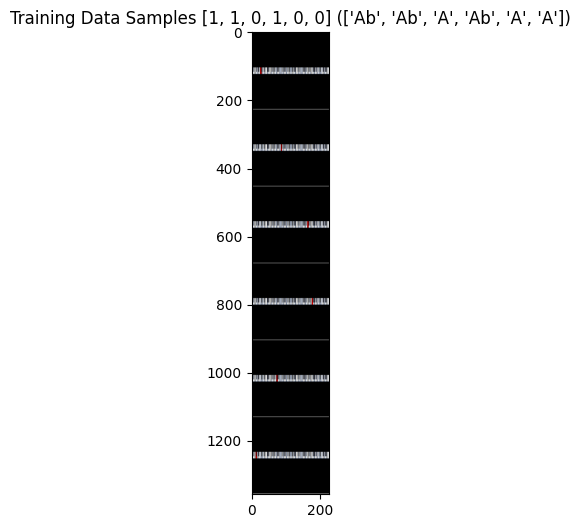

In [6]:
show_data_samples(train_loader, 'Training Data Samples')
# show_data_samples(valid_loader, 'Validation Data Samples')
# show_data_samples(test_loader, 'Test Data Samples')

In [134]:
loaders = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}
for phase, loader in loaders.items():
    print(phase)
    for images, labels in loader:
        print(images.shape, labels)
print(f"train sz: {len(train_loader.dataset)}, valid sz: {len(valid_loader.dataset)}, test sz: {len(test_loader.dataset)}")

train
torch.Size([6, 3, 224, 224]) tensor([1, 1, 0, 1, 0, 0])
valid
torch.Size([4, 3, 224, 224]) tensor([0, 0, 1, 1])
test
torch.Size([4, 3, 224, 224]) tensor([0, 0, 1, 1])
train sz: 6, valid sz: 4, test sz: 4


In [135]:
def search_timm_model(query):
    search_result = [n for n in timm.list_models(pretrained=True) if query in n]
    for i, name in enumerate(search_result):
        print(f'{i} | {name}')
        
search_timm_model('efficientvit_b1')

0 | efficientvit_b1.r224_in1k
1 | efficientvit_b1.r256_in1k
2 | efficientvit_b1.r288_in1k


In [177]:
avail_pretrained_models = timm.list_models(pretrained=True)
len(avail_pretrained_models), avail_pretrained_models[:5]

(1298,
 ['bat_resnext26ts.ch_in1k',
  'beit_base_patch16_224.in22k_ft_in22k',
  'beit_base_patch16_224.in22k_ft_in22k_in1k',
  'beit_base_patch16_384.in22k_ft_in22k_in1k',
  'beit_large_patch16_224.in22k_ft_in22k'])

In [9]:
def model_memory_size(model, input_size=(1, 3, 224, 224), device='cpu'):
    from sys import getsizeof
    import numpy as np
    # Move model to the specified device
    model.to(device)
    # Create a dummy input tensor of the correct size and type, then move to the device
    input_tensor = torch.randn(input_size).to(device)
    # Forward pass (may need to modify depending on model specifics)
    with torch.no_grad():
        model(input_tensor)
    # Calculate total memory allocation by model parameters and buffers
    total_size = 0
    for param in model.parameters():
        total_size += param.element_size() * param.nelement()  # size in bytes
    for buffer in model.buffers():
        total_size += buffer.element_size() * buffer.nelement()  # size in bytes
    return f'Total model size in memory: {total_size / 1024 ** 2:.2f} MB'

In [188]:
# vit_tiny_patch16_224 vs resnet34
# resnet = timm.create_model('resnet34', pretrained=True)
# print(model_memory_size(resnet))
# vit = timm.create_model('vit_tiny_patch16_224', pretrained=True, num_classes=2)
# print(model_memory_size(vit))

In [189]:
# print(vit)

In [136]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=10, device='cuda', num_classes=2):
    model.to(device)

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        # Training phase
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            outputs = model(inputs)
            # Number of classes (max label value + 1)
            # FOR BCE ONLY!
            one_hot_labels = F.one_hot(labels, num_classes=num_classes).float()
            loss = criterion(outputs, one_hot_labels)
            
            # Backward + Optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / total
        epoch_acc = 100. * correct / total

        if epoch % 2 == 0:
            # Validation phase
            model.eval()  # Set model to evaluate mode
            running_loss_val = 0.0
            correct_val = 0
            total_val = 0
            with torch.no_grad():
                for inputs, labels in valid_loader:
                    inputs, labels = inputs.to(device), labels.to(device)

                    outputs = model(inputs)
                    # loss = criterion(outputs, labels) crossent loss
                    one_hot_labels = F.one_hot(labels, num_classes=num_classes).float()
                    loss = criterion(outputs, one_hot_labels)
                    running_loss_val += loss.item() * inputs.size(0)
                    _, predicted = outputs.max(1)
                    total_val += labels.size(0)
                    correct_val += predicted.eq(labels).sum().item()

            epoch_loss_val = running_loss_val / total_val
            epoch_acc_val = 100. * correct_val / total_val

            print(f'Epoch {epoch+1} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.2f}%; Valid Loss: {epoch_loss_val:.4f} Acc: {epoch_acc_val:.2f}%')
            if wandb.run:
                wandb.log({'train_loss': epoch_loss, 'train_acc': epoch_acc, 'valid_loss': epoch_loss_val, 'valid_acc': epoch_acc_val})

In [137]:
# Run the training loop
class Config:
    SEED = SEED

    USE_WANDB = True
    WANDB_PROJECT = 'ai-synth'
    WANDB_ENTITY = 'elles'
    WANDB_EXP_NAME = 'cleanerdata_2class_vit_biggerbatch'
    WANDB_TAGS = ['vit', '2class', 'tiny']
    WANDB_NOTES = '2 class classification with ViT tiny'

    NUM_CLASSES = 2
    EPOCHS = 30
    LOSS = 'bce_logits'
    BATCH_SIZE = batch_size
    
    LR = 0.0001
    WEIGHT_DECAY = 15

cfg = Config()
set_seed(cfg.SEED)
model = timm.create_model('vit_tiny_patch16_224', pretrained=True, num_classes=cfg.NUM_CLASSES)
if cfg.USE_WANDB:
    wandb.init(project=cfg.WANDB_PROJECT, entity=cfg.WANDB_ENTITY, name=cfg.WANDB_EXP_NAME, tags=cfg.WANDB_TAGS, notes=cfg.WANDB_NOTES)
    wandb.config.update(cfg)
    wandb.watch(model, log='all', log_freq=10)

# criterion = nn.CrossEntropyLoss()
if cfg.LOSS == 'bce_logits':
    criterion = nn.BCEWithLogitsLoss() # vit model outputs logits for example
elif cfg.LOSS == 'bce':
    criterion = nn.BCELoss()
elif cfg.LOSS == 'ce':
    criterion = nn.CrossEntropyLoss()
else:
    raise ValueError('Invalid loss function specified')
print(f"using loss: {cfg.LOSS}")
optimizer = optim.Adam(model.parameters(), lr=cfg.LR, weight_decay=cfg.WEIGHT_DECAY)
# print(criterion(torch.tensor([.55, .45], dtype=torch.float32), torch.tensor([1, 0], dtype=torch.float32))) # .69 for bcelogits
# print(criterion(torch.tensor([10, -10], dtype=torch.float32), torch.tensor([1, 0], dtype=torch.float32))) # ~0 [10, -10]
device = 'cuda' if torch.cuda.is_available() else 'cpu'
try:
    train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=cfg.EPOCHS, device=device, num_classes=cfg.NUM_CLASSES)
except KeyboardInterrupt:
    print('Training interrupted')
finally:
    if cfg.USE_WANDB:
        wandb.finish()


using loss: bce_logits
Epoch 1 Train Loss: 0.7428 Acc: 50.00%; Valid Loss: 0.7188 Acc: 50.00%
Epoch 3 Train Loss: 0.7141 Acc: 50.00%; Valid Loss: 0.6980 Acc: 50.00%
Epoch 5 Train Loss: 0.6981 Acc: 50.00%; Valid Loss: 0.6879 Acc: 50.00%
Epoch 7 Train Loss: 0.6907 Acc: 50.00%; Valid Loss: 0.6843 Acc: 50.00%
Epoch 9 Train Loss: 0.6877 Acc: 50.00%; Valid Loss: 0.6835 Acc: 75.00%
Epoch 11 Train Loss: 0.6864 Acc: 66.67%; Valid Loss: 0.6834 Acc: 75.00%
Epoch 13 Train Loss: 0.6855 Acc: 66.67%; Valid Loss: 0.6832 Acc: 75.00%
Epoch 15 Train Loss: 0.6844 Acc: 66.67%; Valid Loss: 0.6829 Acc: 75.00%
Epoch 17 Train Loss: 0.6833 Acc: 66.67%; Valid Loss: 0.6826 Acc: 75.00%
Epoch 19 Train Loss: 0.6823 Acc: 66.67%; Valid Loss: 0.6825 Acc: 75.00%
Epoch 21 Train Loss: 0.6813 Acc: 66.67%; Valid Loss: 0.6826 Acc: 75.00%
Epoch 23 Train Loss: 0.6806 Acc: 66.67%; Valid Loss: 0.6829 Acc: 75.00%
Epoch 25 Train Loss: 0.6799 Acc: 66.67%; Valid Loss: 0.6834 Acc: 75.00%
Epoch 27 Train Loss: 0.6795 Acc: 66.67%; Valid

train_acc,▁▁▁▁▁██████████
train_loss,█▅▃▂▂▂▂▂▁▁▁▁▁▁▁
valid_acc,▁▁▁▁███████████
valid_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,66.66667
train_loss,0.67914
valid_acc,75.0
valid_loss,0.6847


In [15]:
# search timm for vit
# timm.list_models('vit_tiny*')

# TODO: figure out what model is doing heh, why is acc 50%? and can we make model weaker and should we use diff loss and etc?

In [22]:
model.eval()  # Set model to evaluate mode
running_loss = 0.0
correct = 0
total = 0


with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        # loss = criterion(outputs, labels)

        # running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        print(f"predicted: {predicted} vs labels: {labels}")
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

predicted: tensor([0, 1, 1, 1]) vs labels: tensor([0, 0, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{0: 'A', 1: 'Ab', 2: 'B', 3: 'Bb', 4: 'C', 5: 'D', 6: 'E', 7: 'Eb', 8: 'F', 9: 'G', 10: 'Gb'}


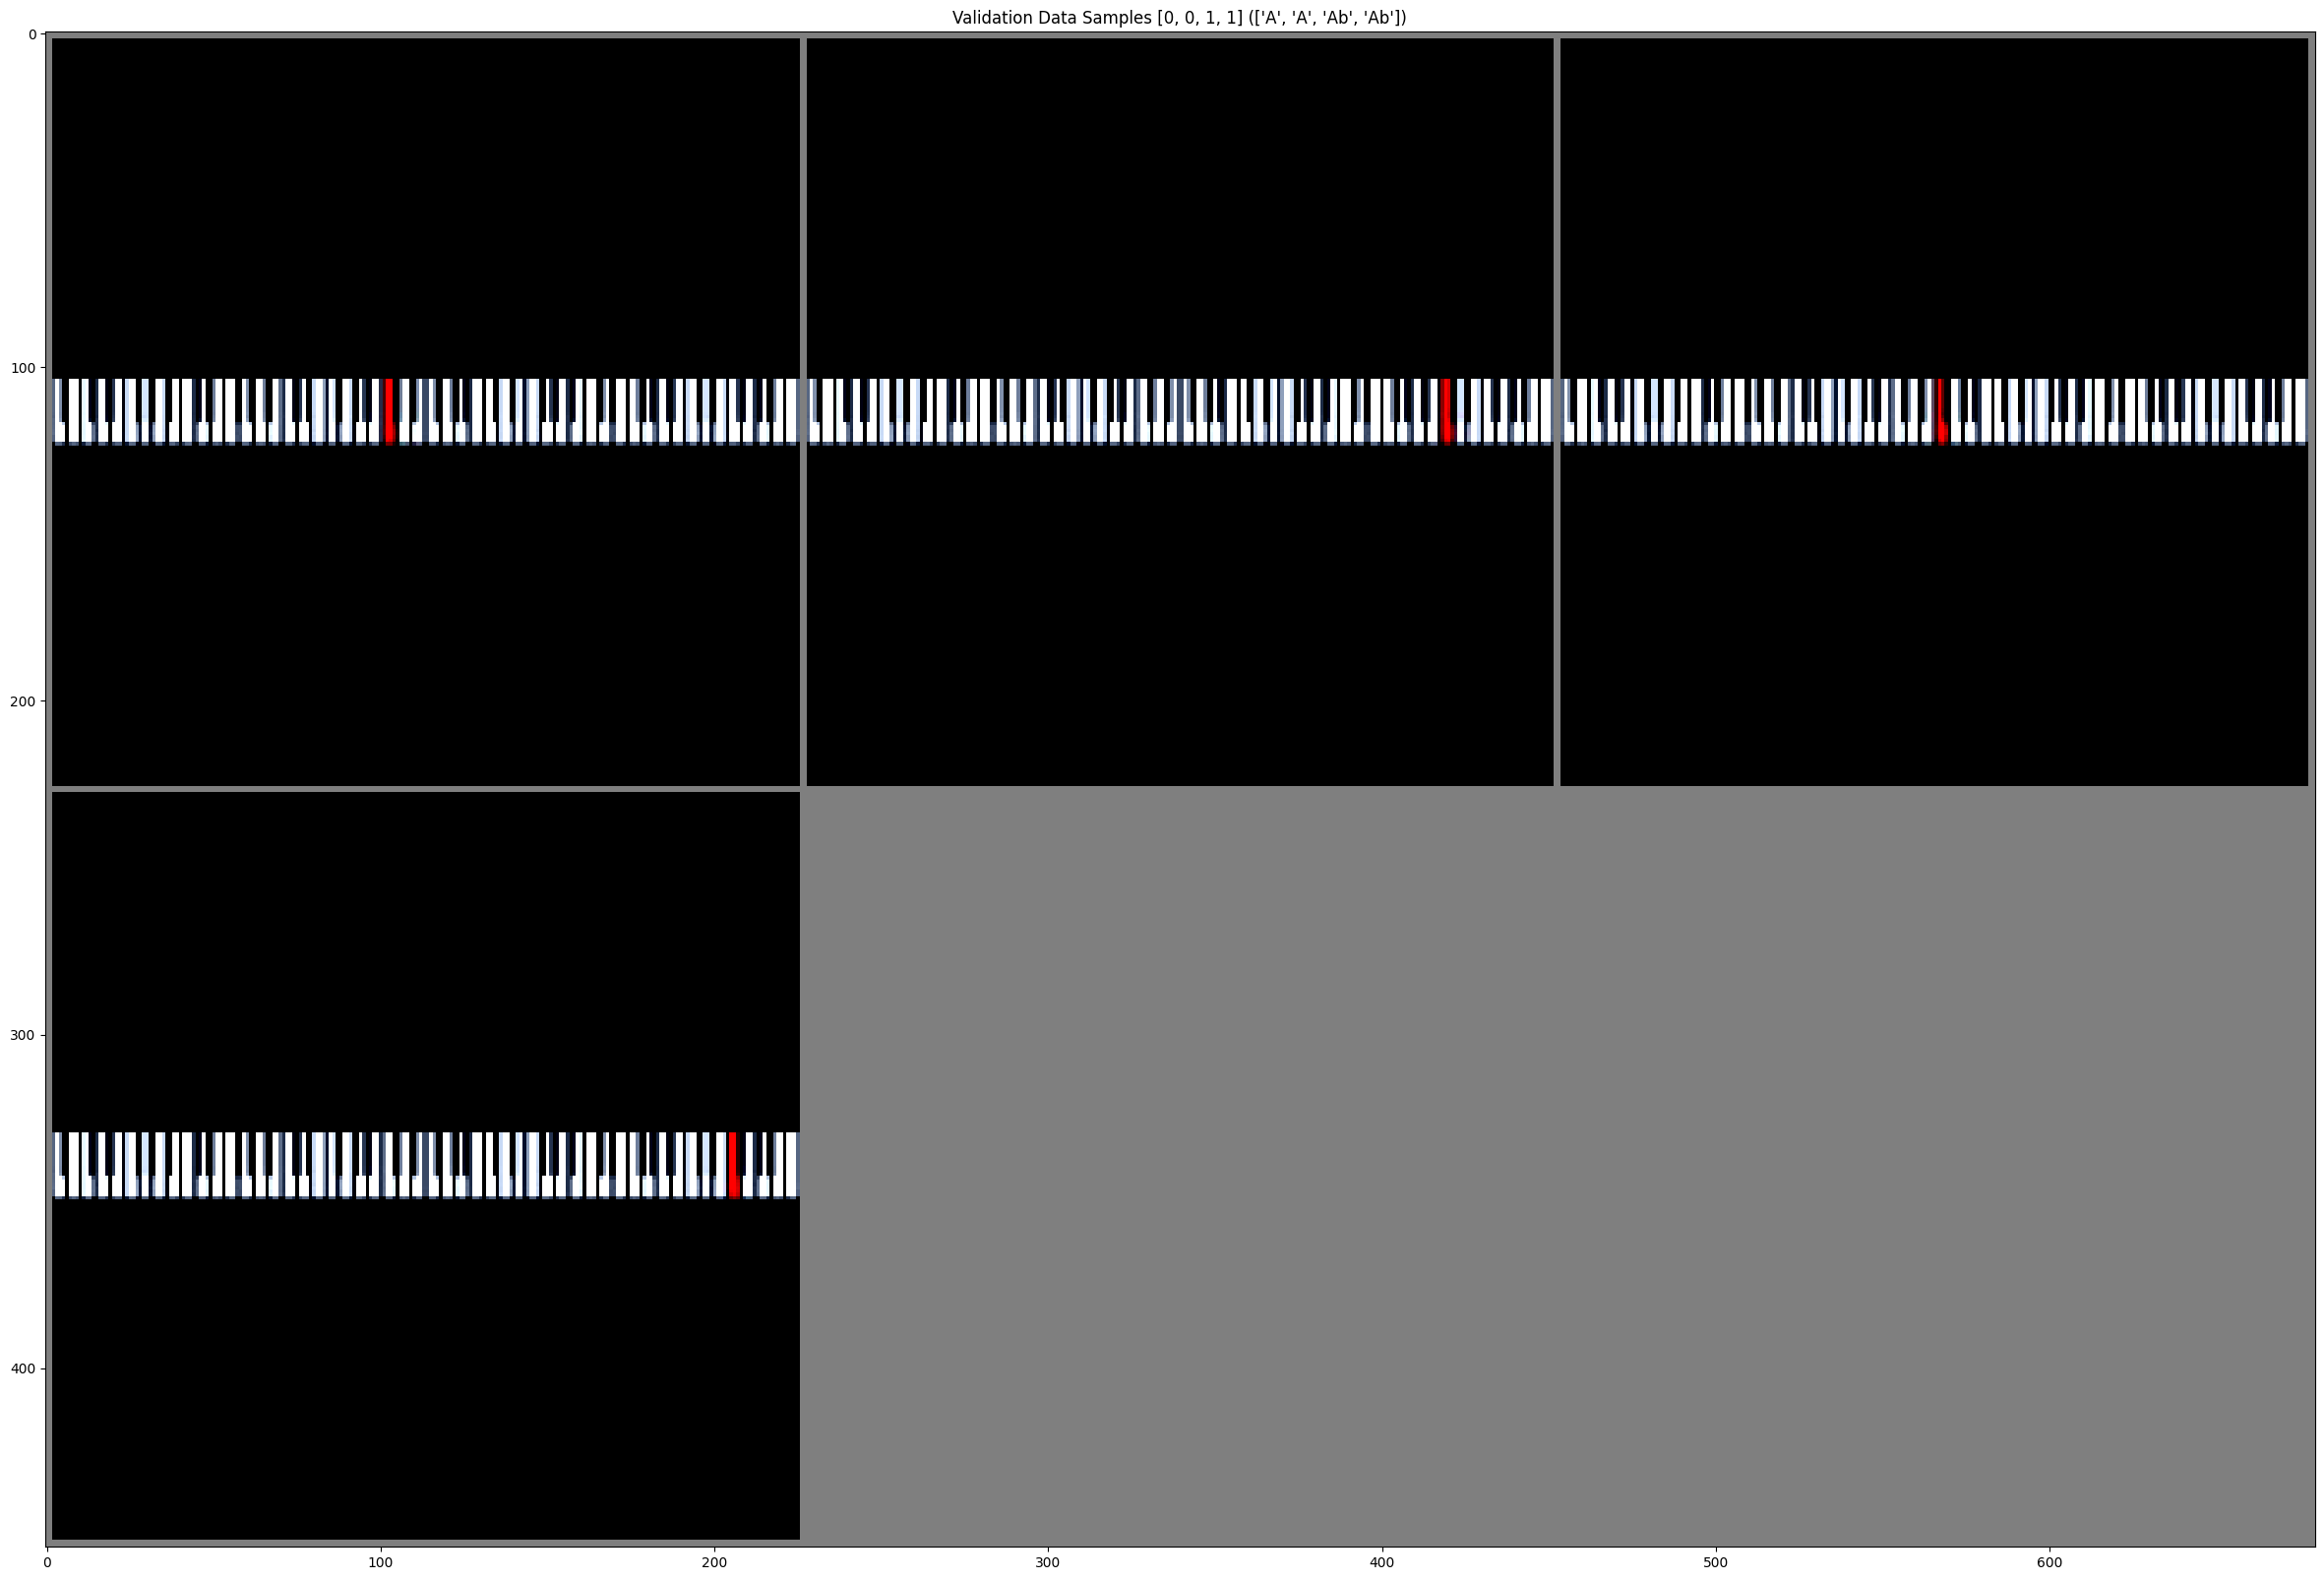

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{0: 'A', 1: 'Ab', 2: 'B', 3: 'Bb', 4: 'C', 5: 'D', 6: 'E', 7: 'Eb', 8: 'F', 9: 'G', 10: 'Gb'}


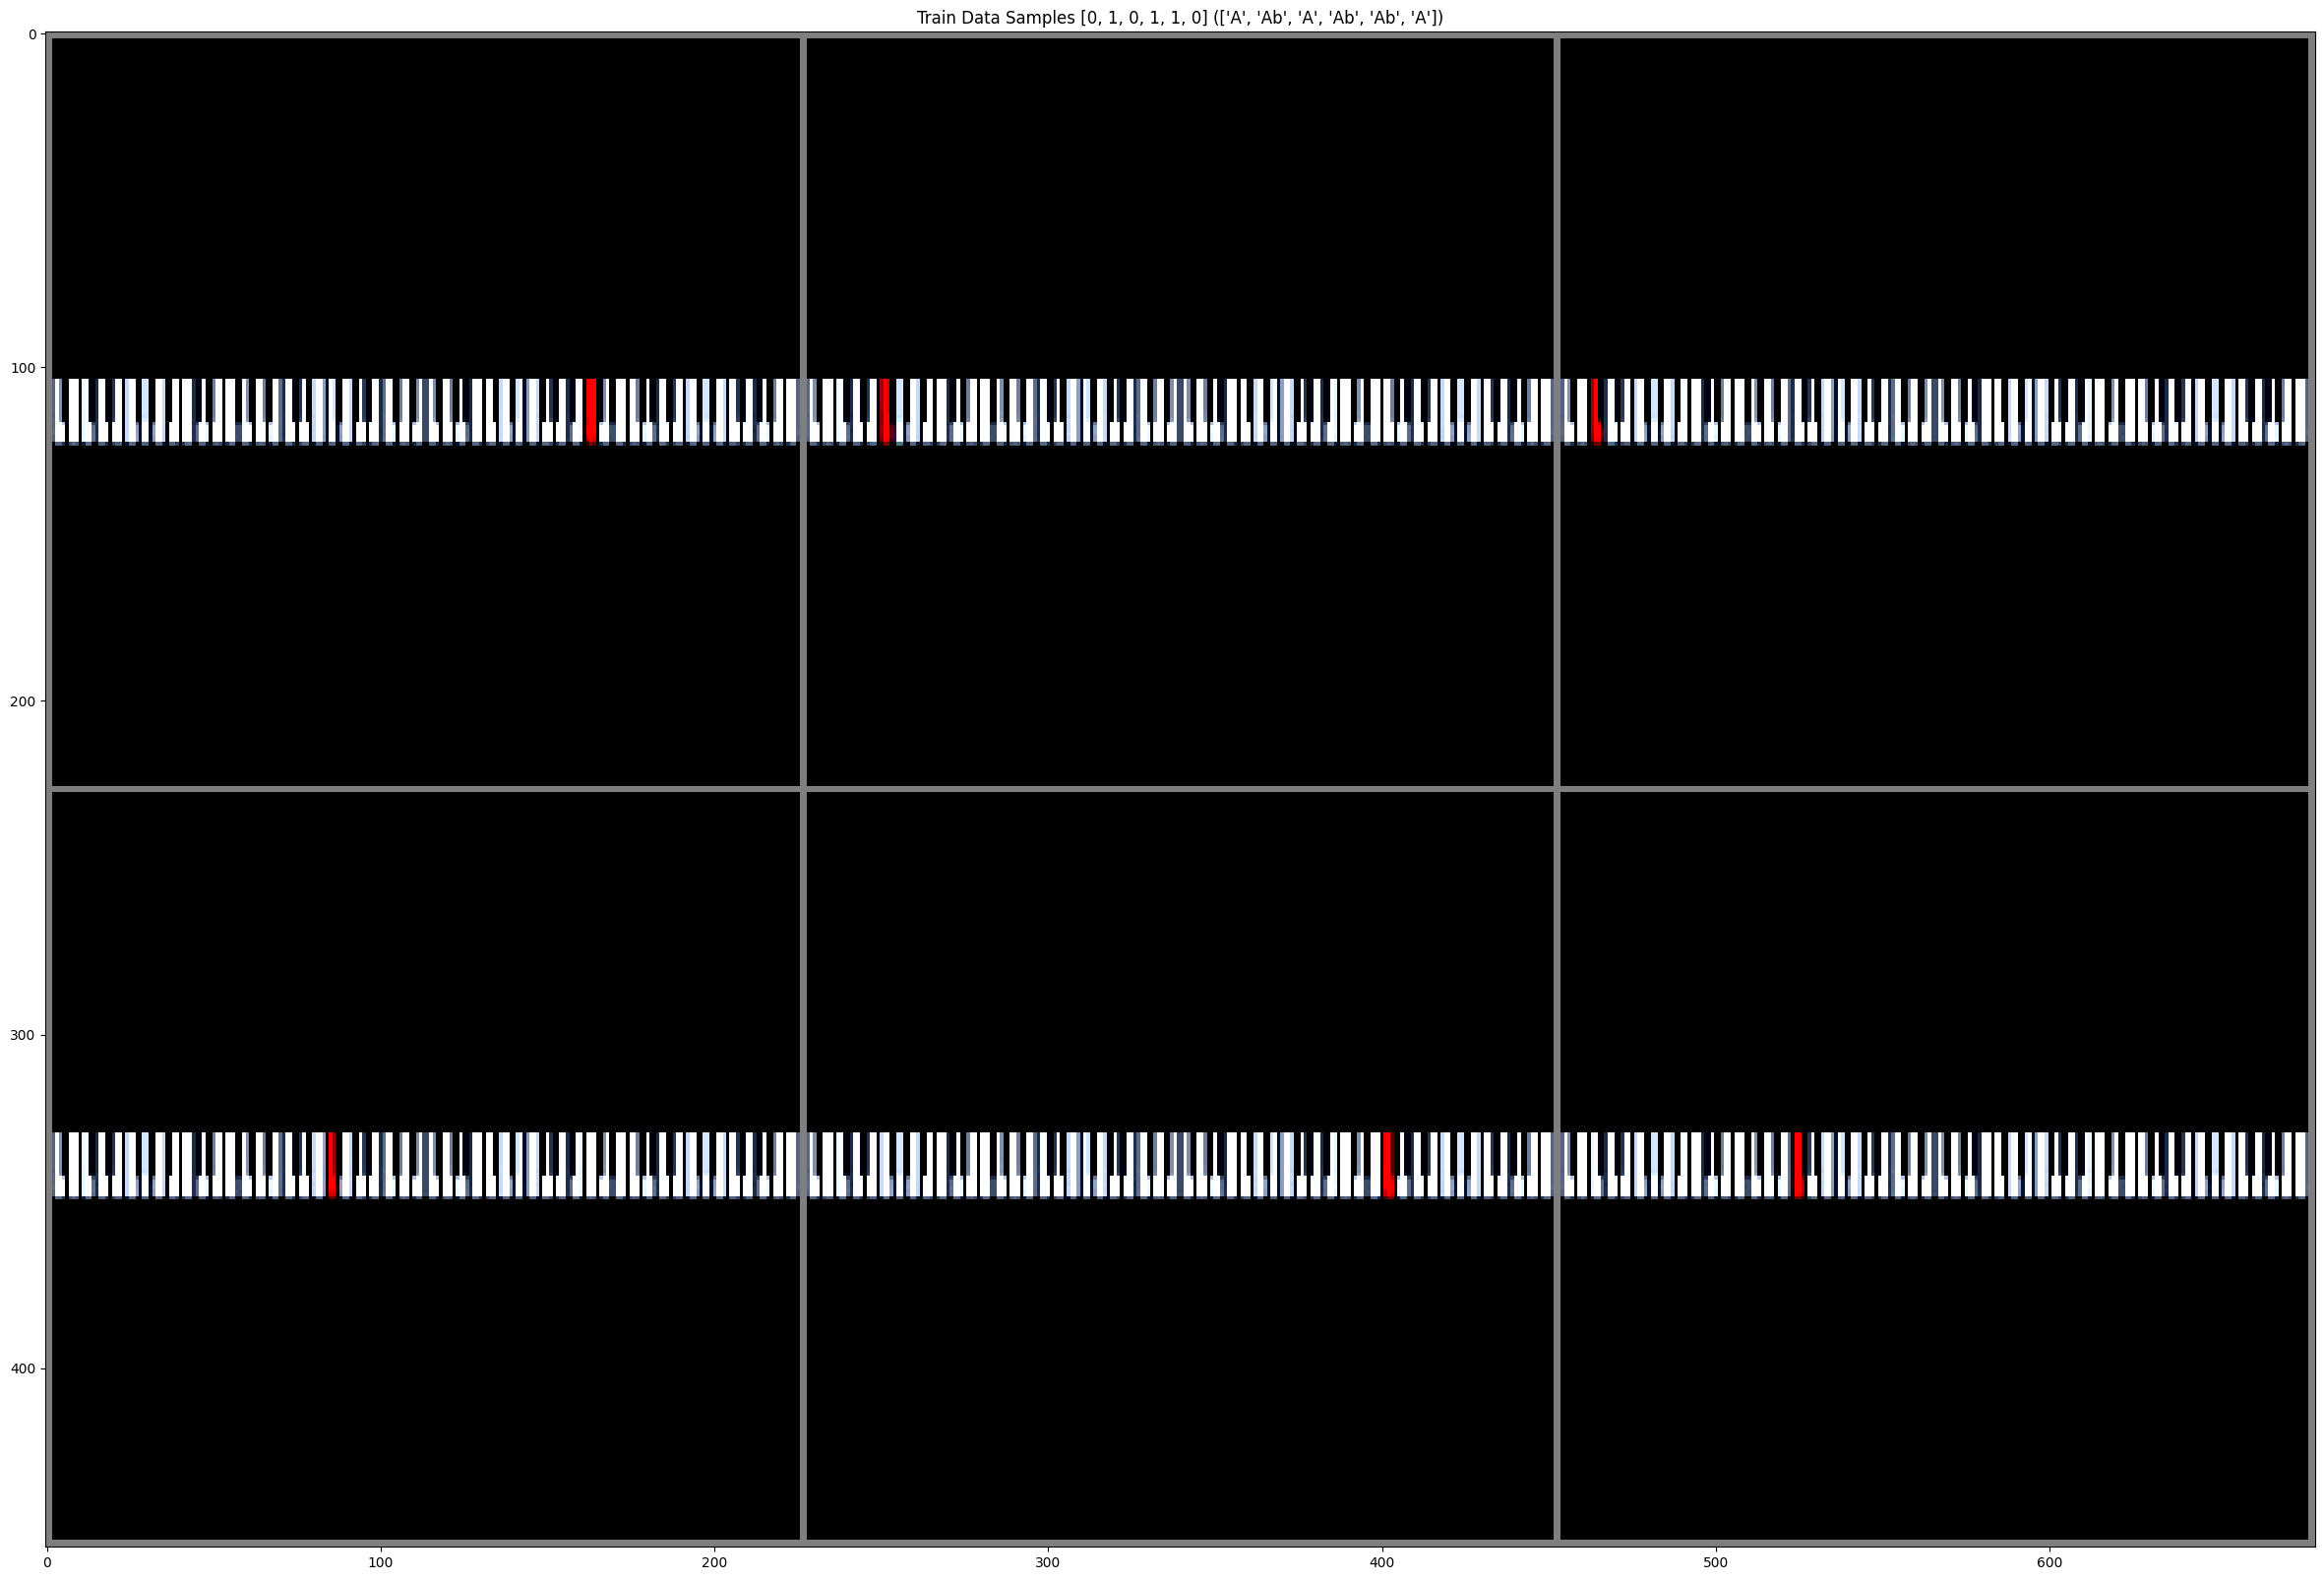

In [29]:
show_data_samples(valid_loader, 'Validation Data Samples', nrow=3, figsize=(30, 20))
show_data_samples(train_loader, 'Train Data Samples', nrow=3, figsize=(30, 20))